# Attention tokens

While exploring some other behaviour I noticed that different heads consistently represent inputs using a small set of tokens, where tokens are generated by directly projecting the components of attention heads (i.e. q, k, v and q*k) onto the residual stream and unembeding the result. I still need to run more comprehensive tests, but so far this seems to hold for any arbitrary inputs. I think this is likely heavily influenced by positional encodings.

Each head appears to use it's attention tokens to chunk inputs in ways specific to that head. Some heads compress inputs into a small number attention tokens - as few as 3-4 for 16 token inputs. Others expand and others linearly track or double with input. My intuition is that this represents how heads structurally decompose inputs to represent meaning for their specific tasks and so provides a means for classifying heads.

Macro patterns across heads also emerge - particularly when considering the element-wise product of q and k. The plot on the left shows a t-SNE plot for the embeddings of the element-wise attention tokens - colors representing layers. The plot on the right shows how attention tokens are shared between all pairs of attention heads.

<div style="display: flex; justify-content: center;">
    <img src="./imdb-tsne.png" alt="Image 1" style="width: 45%; margin-right: 10px;">
    <img src="./shared-token_imdb.png" alt="Image 2" style="width: 45%;">
</div>

In [1]:
import torch
from transformer_lens import HookedTransformer 
import matplotlib.pyplot as plt
import pandas as pd

from utils import *

torch.cuda.empty_cache()
torch.set_grad_enabled(False)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

import warnings
warnings.filterwarnings('ignore')

# NBVAL_IGNORE_OUTPUT
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

Loaded pretrained model gpt2-small into HookedTransformer


The plot below allows you to explore how attention tokens are generated. Note, the colourscale is based on the order in which the attention tokens are discovered during generation meaning brighter colours represent tokens generated later in the process. This means that colours don't represent absolute token values and instead more of a relative position within the generation.

In [2]:
prompt = "The next sentence is false. The previous sentence is true."
cache = run_prompts(model, prompt)

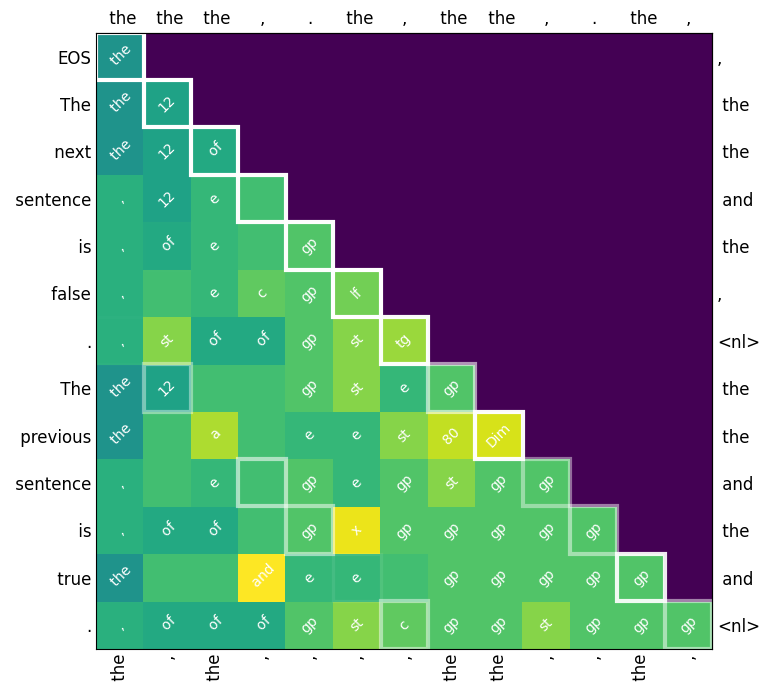

In [3]:
l, h = 0, 1
attn_data = calculate_attns(cache, l, h)
plot = plot_attn(model, attn_data)

Note that the colors are relative and don't represent the same atttention token across heads. 
Instead the patterns show how each head uses the tokens within its vocabulary set.

In [4]:
attn_data = calculate_attns(cache, 0, 0)
attn_data.shape

torch.Size([1, 13, 13, 9])

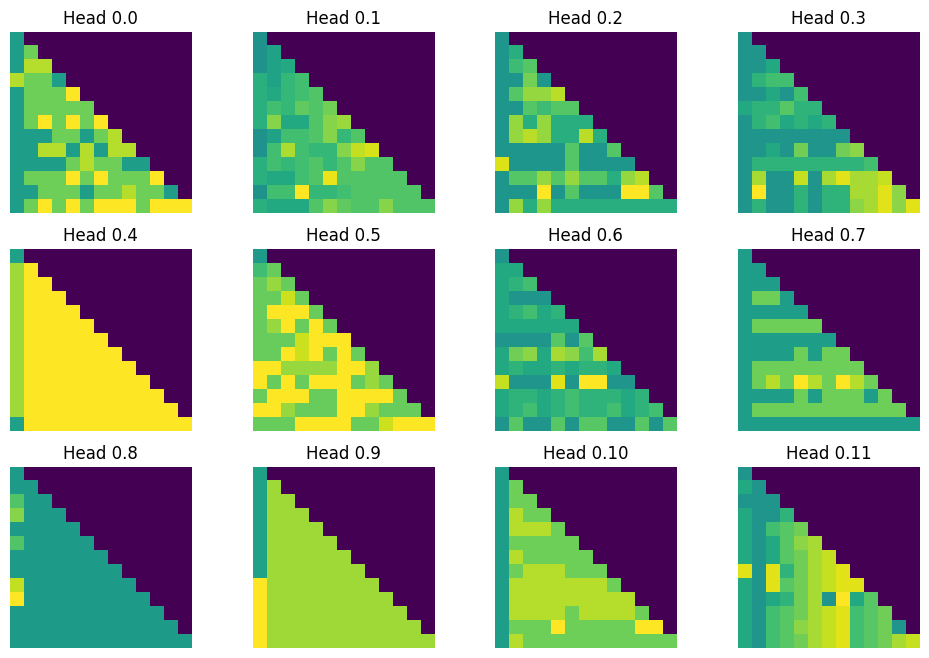

In [5]:
plot, axs = plt.subplots(3, 4, figsize=(12, 8))
for i in range(12):
    attn_data = calculate_attns(cache, l, i)
    plot_attn(cache, attn_data, ax=axs[i // 4, i % 4], hide_labels=True, title=f"Head {l}.{i}")

To get a sense of how attention tokens are generated I want to test over a reasonably large and varied inputs. For the time being I'm using the imdb dataset because it contains a wide variety of natural language from multiple authors and is relatively small.

The code below extracts 3 random prompts from the dataset and uses them as the input into the model. We then use the cached activations to generate a dataset of attention tokens for each component across each head. The length of each prompt is capped at 16 tokens.

In [6]:
from datasets import load_dataset

dataset = load_dataset("imdb")
prompts = random.choices(dataset["train"]["text"], k=8)
prompts = model.to_string(model.to_tokens(prompts)[:, :16])
filename = f'../data/imdb.csv'
df = load_or_create_data(filename, model, *prompts)
df

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


,batch,pos_x,pos_y,layer,head,input,attn,qk,dp,q,k,v
0,0,0,0,0.0,0.0,50256.0,1.000000,262.0,357.0,11.0,11.0,262.0
1,0,1,0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
2,0,2,0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
3,0,3,0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
4,0,4,0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
332923,7,12,16,11.0,11.0,2863.0,0.021062,6362.0,23712.0,23616.0,46383.0,29952.0
332924,7,13,16,11.0,11.0,2863.0,0.048909,44686.0,23712.0,23616.0,46383.0,29952.0
332925,7,14,16,11.0,11.0,2863.0,0.026155,6362.0,23712.0,23616.0,46383.0,29952.0
332926,7,15,16,11.0,11.0,2863.0,0.062322,17148.0,23712.0,23616.0,46383.0,29952.0


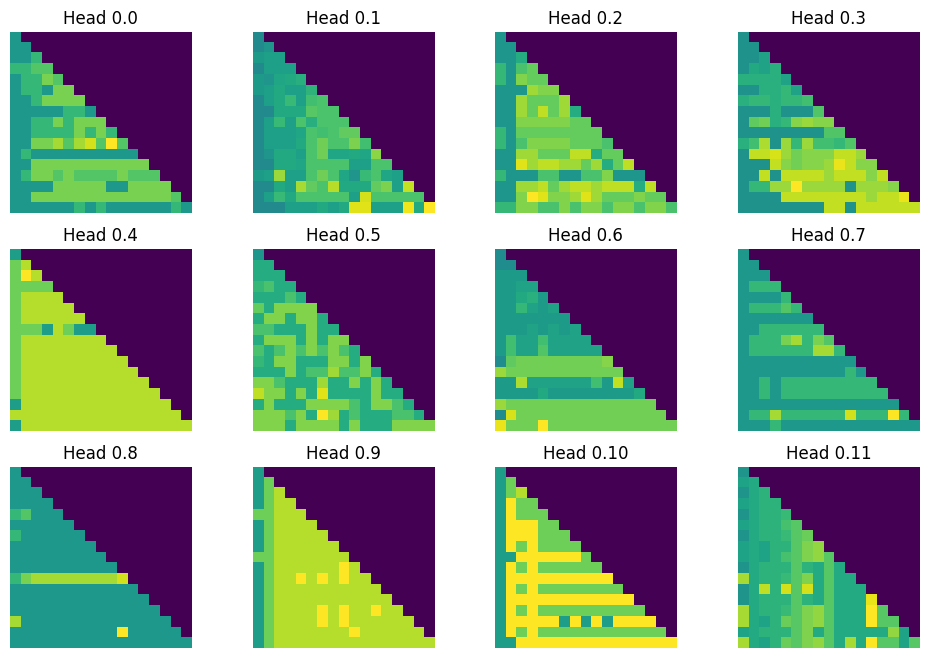

In [7]:
plot, axs = plt.subplots(3, 4, figsize=(12, 8))
for i in range(12):
    l, h = get_head_index(i)
    attn_data = df_to_tensor(df, l, h)
    plot_attn(cache, attn_data, ax=axs[i // 4, i % 4], hide_labels=True, title=f"Head {l}.{h}")

While it's interesting to look at the patterns that emerge in the token plots, and I think it can be useful for interpreting head behaviour (see below), it doesn't help to understand any macro patterns that may exist across the model heads.

Calculating fequencies of each token shows a dramatic compaction down to ~1200 tokens for the element-wise product and ~10000 for the Q and K components and ~25000 for V. These numbers seem relatively invariant to actual token input and length - see random token experiments below for more details.

In [8]:
token_counts = calculate_token_frequencies(model, df)
token_counts

,head_index,token,qk,dp,q,k,v,qk_rank,dp_rank,q_rank,k_rank,v_rank,token str
0,0.0,11,135.0,24.0,730.0,309.0,126.0,3.0,5.0,1.0,3.0,3.0,","
1,0.0,198,29.0,0.0,0.0,0.0,66.0,6.0,6.0,3.0,10.0,4.0,\n
2,0.0,262,0.0,0.0,494.0,379.0,461.0,10.0,6.0,2.0,2.0,2.0,the
3,0.0,287,0.0,0.0,0.0,394.0,0.0,10.0,6.0,3.0,1.0,6.0,in
4,0.0,290,10.0,649.0,0.0,11.0,522.0,9.0,1.0,3.0,6.0,1.0,and
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25561,143.0,49268,0.0,0.0,0.0,3.0,0.0,8.0,30.0,21.0,28.0,13.0,Carth
25562,143.0,49309,0.0,0.0,0.0,50.0,0.0,8.0,30.0,21.0,4.0,13.0,raised
25563,143.0,49507,0.0,0.0,0.0,2.0,0.0,8.0,30.0,21.0,29.0,13.0,curls
25564,143.0,49940,0.0,0.0,0.0,2.0,0.0,8.0,30.0,21.0,29.0,13.0,jing


From left to right: token frequencies, attention token count by head, and attention token count by layer.
From top to bottom: query, key, value, and element-wise attention tokens.
Colors represent layer index.

<Axes: >

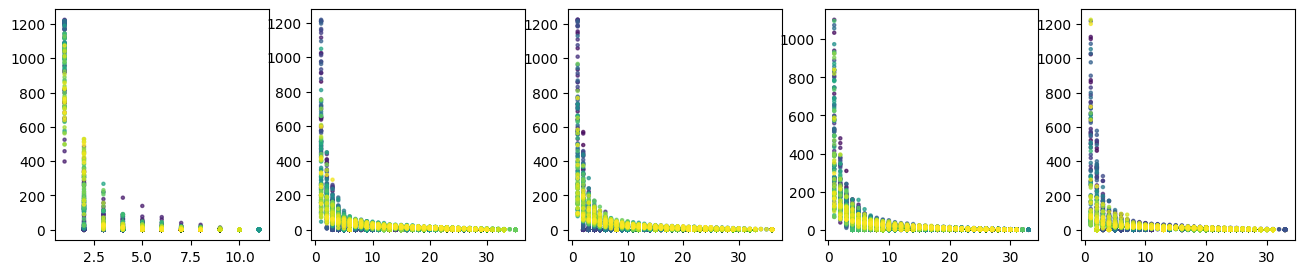

In [9]:
fig, axs = plt.subplots(1, 5, figsize=(16, 3))
plot_scatter(token_counts['qk_rank'], token_counts['qk'], token_counts['head_index'], ax=axs[0])
plot_scatter(token_counts['dp_rank'], token_counts['dp'], token_counts['head_index'], ax=axs[1])
plot_scatter(token_counts['q_rank'], token_counts['q'], token_counts['head_index'], ax=axs[2])
plot_scatter(token_counts['k_rank'], token_counts['k'], token_counts['head_index'], ax=axs[3])
plot_scatter(token_counts['v_rank'], token_counts['v'], token_counts['head_index'], ax=axs[4])

I've tried various dimensionality reduction techniques, but t-SNE offers by far the most striking visualizations. The plots are unusualy for t-SNE and suggest a highly stucutured dataset, but this is generated from randomly selected snippets natural language.

The plots below, from top clockwise, show the t-SNE representations for the embeddings of the element-wise, query, key, and value attention tokens. Colours represent the layer index.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


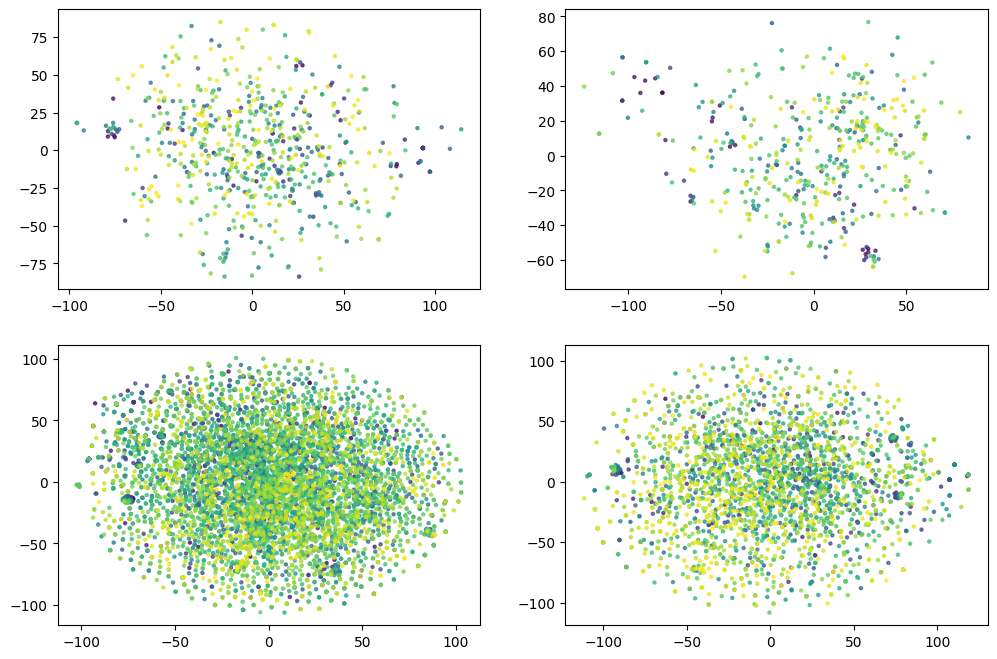

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plot_token_embeddings(model, token_counts[token_counts['dp'] != 0], 'TSNE', ax=axs[0][0])
plot_token_embeddings(model, token_counts[token_counts['q'] != 0], 'TSNE', ax=axs[0][1])
plot_token_embeddings(model, token_counts[token_counts['k'] != 0], 'TSNE', ax=axs[1][0])
plot_token_embeddings(model, token_counts[token_counts['v'] != 0], 'TSNE', ax=axs[1][1])

Calculating token frequencies shows that patterns exist in how attention tokens are shared between heads - at least one token is shared between every head pair and at most 4 are shared. This forms a pattern that could point to how heads collaborate under different tasks

Below, clockwise from top, are heatmaps for how each pair of heads share attention tokens for the element-wise q*k product, q, k and v components.

In [11]:
shared_tokens = calculate_shared_tokens(token_counts)
shared_tokens

,head_index_1,head_index_2,qk_count,qk_shared_tokens,dp_count,dp_shared_tokens,q_count,q_shared_tokens,k_count,k_shared_tokens,v_count,v_shared_tokens
0,0.0,1.0,2,"290, 11",1,11,2,"11, 262",4,"290, 11, 262, 287",4,"290, 11, 198, 262"
1,0.0,2.0,2,"11, 198",2,"290, 11",2,"11, 262",3,"290, 11, 262",4,"290, 11, 198, 262"
2,0.0,3.0,2,"290, 11",1,11,2,"11, 262",3,"290, 11, 262",2,"11, 262"
3,0.0,4.0,1,11,2,"290, 11",2,"11, 262",2,"11, 262",3,"290, 11, 262"
4,0.0,5.0,1,11,2,"290, 11",2,"11, 262",4,"290, 11, 262, 287",2,"11, 262"
...,...,...,...,...,...,...,...,...,...,...,...,...
10291,140.0,142.0,1,11,0,,0,,0,,0,
10292,140.0,143.0,1,11,0,,0,,0,,0,
10293,141.0,142.0,2,"11, 262",0,,1,49836,4,"21016, 43177, 21890, 40635",0,
10294,141.0,143.0,2,"11, 262",0,,0,,5,"43177, 47723, 48366, 48527, 23484",0,


In [12]:
shared_tokens[(shared_tokens['head_index_1'] == 24) & (shared_tokens['head_index_2'] < 36)].head(50)

,head_index_1,head_index_2,qk_count,qk_shared_tokens,dp_count,dp_shared_tokens,q_count,q_shared_tokens,k_count,k_shared_tokens,v_count,v_shared_tokens
3156,24.0,25.0,2,"257, 11",2,"11, 262",4,"290, 14, 198, 262",6,"290, 262, 11, 366, 560, 286",2,"290, 262"
3157,24.0,26.0,0,,2,"290, 262",3,"11, 198, 262",3,"290, 11, 12",4,"290, 11, 198, 262"
3158,24.0,27.0,1,11,3,"290, 11, 262",3,"290, 11, 262",5,"290, 262, 11, 12, 284",3,"11, 198, 262"
3159,24.0,28.0,1,11,3,"11, 13, 262",4,"290, 11, 198, 262",2,"290, 11",4,"290, 11, 198, 262"
3160,24.0,29.0,1,11,1,262,3,"11, 198, 262",5,"257, 290, 262, 11, 286",3,"290, 11, 262"
3161,24.0,30.0,0,,5,"290, 262, 11, 13, 284",5,"290, 198, 262, 11, 14",6,"290, 262, 11, 12, 14, 284",4,"290, 11, 262, 287"
3162,24.0,31.0,1,11,2,"290, 262",2,"11, 262",3,"11, 262, 286",4,"290, 11, 198, 262"
3163,24.0,32.0,1,11,2,"11, 262",2,"290, 262",5,"290, 262, 11, 12, 284",4,"290, 11, 198, 262"
3164,24.0,33.0,0,,2,"11, 262",3,"290, 11, 262",3,"257, 890, 366",4,"290, 11, 262, 287"
3165,24.0,34.0,0,,3,"290, 11, 262",2,"198, 262",5,"290, 262, 329, 74, 366",4,"290, 11, 262, 287"


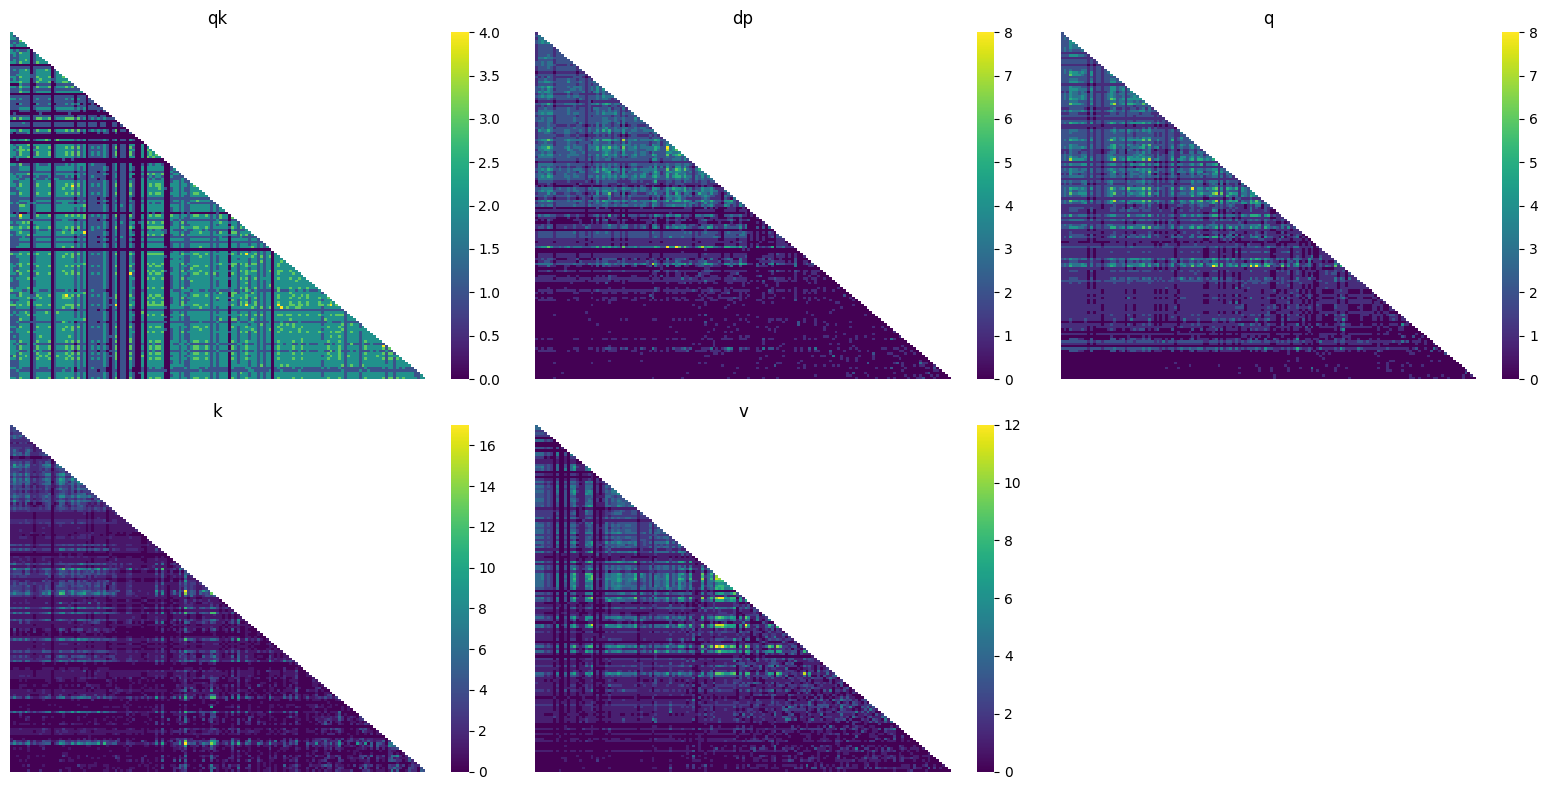

In [13]:
token_types = ['qk', 'dp', 'q', 'k', 'v']
num_subplots = len(token_types)
rows = 2
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(16, 8))
axes = axes.flatten()

for i, token_type in enumerate(token_types):
    ax = plot_shared_token_heatmap(shared_tokens, token_type, ax=axes[i])

for i in range(num_subplots, rows * cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### Random inputs

Testing with random token inputs provides some insights into how the heads behave in a "default" state. It also makes it easy to change the input length without worrying about being distracted by how that affects the semantic/grammatical structure of the input.

Here are the heads of the first layer using a single random token repeated 62 times.

In [14]:
filename = f'../data/random-single-32.csv'
token = random.randint(0, 50257)
prompt = torch.full((1, 30), token)
random_single_df = load_or_create_data(filename, model, prompt)
random_single_df

,layer,head,input,attn,qk,dp,q,k,v
0,0.0,0.0,50256.0,1.000000,262.0,357.0,11.0,11.0,262.0
1,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...
138379,11.0,11.0,16347.0,0.000579,43407.0,47992.0,1360.0,38518.0,43617.0
138380,11.0,11.0,16347.0,0.000598,43407.0,47992.0,1360.0,38518.0,43617.0
138381,11.0,11.0,16347.0,0.000624,43407.0,47992.0,1360.0,38518.0,43617.0
138382,11.0,11.0,16347.0,0.000650,43407.0,47992.0,1360.0,38518.0,43617.0


InvalidIndexError: (slice(None, None, None), slice(None, None, None), slice(None, None, None), 3)

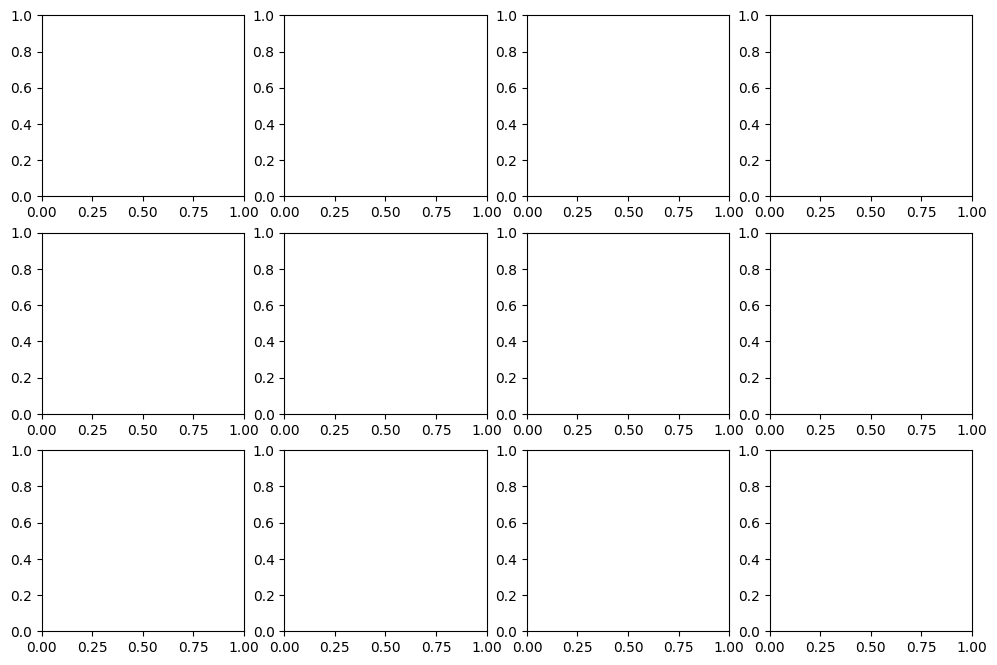

In [15]:
plot, axs = plt.subplots(3, 4, figsize=(12, 8))
for i in range(12):
    l, h = get_head_index(i)
    attn_data = df_to_tensor(random_single_df, l, h)
    plot_attn(model, random_single_df, ax=axs[i // 4, i % 4], hide_labels=True, title=f"Head {l}.{h}", feature=5)

In [ ]:
filename = f'../data/random-full-32.csv'
random_full_df = load_or_create_data(filename, model, torch.randint(0, 50257, (1, 32)))
random_full_df

In [ ]:
prompt = torch.randint(0, 50257, (1, 32))
cache = run_prompts(model, *model.to_string(prompt))

plot, axs = plt.subplots(3, 4, figsize=(12, 8))
for i in range(12):
    attn_data = calculate_attns(cache, 0, i)
    plot_attn(cache, attn_data, ax=axs[i // 4, i % 4], hide_labels=True, title=f"Head {i}")

In [ ]:
filename = f'../data/random-seq-32.csv'
random_seq_df = load_or_create_data(filename, model, torch.randint(0, 50257, (1, 32)).repeat(1, 10))
random_seq_df

In [ ]:
plot, axs = plt.subplots(3, 4, figsize=(12, 8))
for i in range(12):
    plot_attn(model, random_seq_df, ax=axs[i // 4, i % 4], hide_labels=True, title=f"Head {i}")

While the specific patterns change, if you run this multiple times you can see clear motifs emerge that identify specific heads. You can also see broad similarities in the patterns produced from the same head across inputs.

Again, to get a better idea of how the attention tokens a distributed across heads we can look at the t-SNE plots and shared tokens. The t-SNE plots show similar patterns for the element-wise tokens, but much simpler more structured outputs for q, k and v tokens. This makes sense given the constrained input/output of the random sequence.

In [ ]:
token_counts = calculate_token_frequencies(model, random_seq_df)
token_counts

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plot_token_embeddings(model, token_counts[token_counts['dp'] != 0], 'TSNE', ax=axs[0][0])
plot_token_embeddings(model, token_counts[token_counts['q'] != 0], 'TSNE', ax=axs[0][1])
plot_token_embeddings(model, token_counts[token_counts['k'] != 0], 'TSNE', ax=axs[1][0])
plot_token_embeddings(model, token_counts[token_counts['v'] != 0], 'TSNE', ax=axs[1][1])

In [ ]:
shared_tokens = calculate_shared_tokens(token_counts)
shared_tokens

In [ ]:
token_types = ['qk', 'dp', 'q', 'k', 'v']
num_subplots = len(token_types)
rows = 2
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
axes = axes.flatten()

for i, token_type in enumerate(token_types):
    ax = plot_shared_token_heatmap(shared_tokens, token_type, ax=axes[i])

for i in range(num_subplots, rows * cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

The shared token plots are similar to the natural language examples, but there's less structure and a slight hyperbolic nature to some regions.

## Input length

## Zooming in on subgroups

I have some about how to use attention tokens, and the patterns they form between heads, to uncover model behaviours, but for now I want to focus on the indirect object identification task because it's already well understood. The paper identifies 5 head classes that contribute to completing the correct token: previous token heads, duplicate token heads, induction heads, s-inhibition heads, and name mover heads.

![Head categories](./images/ioi-heads.png)

First, we need to define an input dataset for the IOI task.

In [ ]:
from itertools import permutations 

template = "{0} and{1} went to the store.{0} gave the bag to{1}."
names = (" Phil", " Bob", " James", " Paul")

prompts = [
    template.format(S, IO, S, IO)
    for S, IO in permutations(names, 2)
]

len(prompts), prompts[:5]

In [ ]:
filename = f'../data/ioi.csv'
ioi_df = load_or_create_data(filename, model, *prompts)
ioi_df

### Name mover heads

In [ ]:
heads = [(9, 9), (9, 6), (10, 0)]
plot, axs = plt.subplots(1, 3, figsize=(12, 8))

for i, (l, h) in enumerate(heads):
    attn_data = calculate_attns(cache, l, h)
    plot_attn(model, attn_data, ax=axs[i], hide_labels=True, title=f"IOI // Head {l}.{h}")

### S-inhibition heads

In [ ]:
heads = [(7, 3), (7, 9), (8, 6), (8, 10)]
plot, axs = plt.subplots(1, 4, figsize=(12, 8))

for i, (l, h) in enumerate(heads):
    attn_data = calculate_attns(cache, l, h)
    plot_attn(model, attn_data, ax=axs[i], hide_labels=True, title=f"IOI // Head {l}.{h}")

### Duplicate token heads

In [ ]:
heads = [(0, 1), (3, 0), (0, 10)]
plot, axs = plt.subplots(1, 3, figsize=(12, 8))

for i, (l, h) in enumerate(heads):
    attn_data = calculate_attns(cache, l, h)
    plot_attn(model, attn_data, ax=axs[i], hide_labels=True, title=f"Head {l}.{h}")

### Induction and previous token heads

In [ ]:
heads = [(2, 2), (4, 11)]
plot, axs = plt.subplots(1, 2, figsize=(12, 8))

for i, (l, h) in enumerate(heads):
    attn_data = calculate_attns(cache, l, h)
    plot_attn(model, attn_data, ax=axs[i], hide_labels=True, title=f"IOI // Head {l}.{h}")

In [ ]:
heads = [(5, 5), (6, 9), (5, 8), (5, 9)]
plot, axs = plt.subplots(1, 4, figsize=(12, 8))

for i, (l, h) in enumerate(heads):
    attn_data = calculate_attns(cache, l, h)
    plot_attn(model, attn_data, ax=axs[i], hide_labels=True, title=f"IOI // Head {l}.{h}")

### Negative name-mover heads

In [ ]:
heads = [(10, 7), (11, 10)]
plot, axs = plt.subplots(1, 2, figsize=(12, 8))

for i, (l, h) in enumerate(heads):
    attn_data = calculate_attns(cache, l, h)
    plot_attn(model, attn_data, ax=axs[i], hide_labels=True, title=f"IOI // Head {l}.{h}")

### Backup name-mover heads

In [ ]:
heads = [(9, 0), (9, 7), (10, 1), (10, 2), (10, 6), (10, 10), (11, 2), (11, 9)]
plot, axs = plt.subplots(2, 4, figsize=(12, 8))

for i, (l, h) in enumerate(heads):
    attn_data = calculate_attns(cache, l, h)
    plot_attn(model, attn_data, ax=axs[i//4, i%4], hide_labels=True, title=f"IOI // Head {l}.{h}")